In [2]:
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [3]:
# Assuming you have a CSV file named 'arabic_dataset_classifiction.csv' with a "label" column
csv_file_path = '/content/ar_tweets.csv'

# Read the CSV file into a Pandas DataFrame
ar_tweets = pd.read_csv(csv_file_path)

In [4]:
ar_tweets

,text,label
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0
...,...,...
59995,أطلق الاتحاد الدولي لكرة القدم فيفا في شتنبر ا...,4
59996,أعلنت رابطة الدوري الإنجليزي الممتاز لكرة القد...,4
59997,أنقذ الحكم الشاب دانييل غارسيا حياة مهاجم فريق...,4
59998,الدوري الإنجليزي سندرلاند مانشستر يونايتد كريس...,4


In [6]:
# Assuming your CSV file has columns 'text' and 'label'
data = list(zip(ar_tweets['text'].astype(str), ar_tweets['label'].astype(str)))  # Ensure the 'text' and 'label' columns are treated as strings

In [7]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
# Define a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(int(label))  # Assuming labels are integers representing the class index
        }

In [9]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Create datasets and dataloaders
train_dataset = SentimentDataset(train_data, tokenizer)
test_dataset = SentimentDataset(test_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [12]:
# Define training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Get model predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Print loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

Epoch 1/5: 100%|██████████| 6000/6000 [27:19<00:00,  3.66it/s]


Epoch 1/5 - Average Loss: 0.2783 - Accuracy: 0.9123


Epoch 2/5: 100%|██████████| 6000/6000 [27:01<00:00,  3.70it/s]


Epoch 2/5 - Average Loss: 0.1841 - Accuracy: 0.9421


Epoch 3/5: 100%|██████████| 6000/6000 [26:57<00:00,  3.71it/s]


Epoch 3/5 - Average Loss: 0.1506 - Accuracy: 0.9537


Epoch 4/5: 100%|██████████| 6000/6000 [26:49<00:00,  3.73it/s]


Epoch 4/5 - Average Loss: 0.1210 - Accuracy: 0.9626


Epoch 5/5: 100%|██████████| 6000/6000 [26:52<00:00,  3.72it/s]

Epoch 5/5 - Average Loss: 0.1034 - Accuracy: 0.9682


In [14]:
# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in tqdm(test_dataloader, desc='Evaluating'):
    inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 1500/1500 [02:43<00:00,  9.19it/s]


In [15]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9406


In [16]:
# Save model locally in Colab
model.save_pretrained('/content/sentimental_analysis_model')
tokenizer.save_pretrained('/content/tokenizer')

('/content/tokenizer/tokenizer_config.json',
 '/content/tokenizer/special_tokens_map.json',
 '/content/tokenizer/vocab.txt',
 '/content/tokenizer/added_tokens.json')

In [17]:
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions)

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[2237   10   60   40   45]
 [   4 2298   28   19    8]
 [  17   24 2225   94   22]
 [  51   49  188 2130   15]
 [   7   14   10    8 2397]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2392
           1       0.96      0.97      0.97      2357
           2       0.89      0.93      0.91      2382
           3       0.93      0.88      0.90      2433
           4       0.96      0.98      0.97      2436

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



Testing Dataset Label Distribution:
4    2436
3    2433
0    2392
2    2382
1    2357
dtype: int64
True: 1, Predicted: 1
True: 3, Predicted: 3
True: 3, Predicted: 3
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 4, Predicted: 4
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 2, Predicted: 2


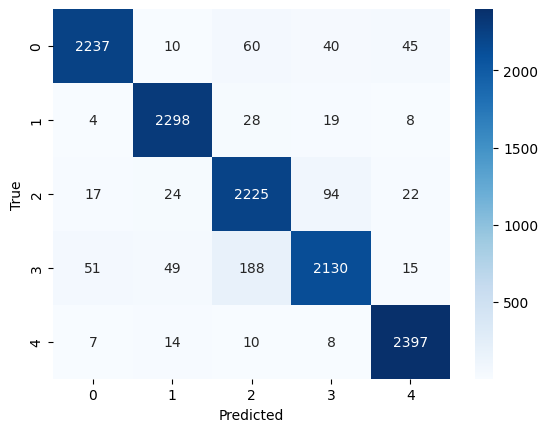

In [18]:
# Print the distribution of labels in the testing dataset
print("Testing Dataset Label Distribution:")
print(pd.Series(true_labels).value_counts())

# Print true labels and predicted labels for a small sample
for true, pred in zip(true_labels[:10], predictions[:10]):
    print(f"True: {true}, Predicted: {pred}")

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()